# XGBOOST NOTEBOOK

In [73]:
import pandas as pd
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

train_lab = train.iloc[:,-1]
train = train.iloc[:,:-1]

train_len = train.shape[0]


In [74]:
print(test["Id"])

0       1461
1       1462
2       1463
3       1464
4       1465
        ... 
1454    2915
1455    2916
1456    2917
1457    2918
1458    2919
Name: Id, Length: 1459, dtype: int64


In [75]:
all = pd.concat([train, test])


In [76]:
import sklearn
print(sklearn.__version__)

0.24.1


In [106]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing
import numpy as np

def data_processor(df, train_len):
    
    types = df.dtypes
    cat_dict = {}
    cat_labels = []
    cat_big_labels = []
    reverse_cat_dict = {}
    new_arr = []
    first = True
    non_cat = []

    for ke, type in zip(df.columns, types):
        if type == "object":
            le = OneHotEncoder()
            if df[ke].isnull().values.any():
                ifnan = True
            else:
                ifnan = False

            if ifnan:
                unique = np.expand_dims(np.asarray(["nan"] + list(df[ke].dropna().unique())), axis = 1)
            else:
                unique = np.expand_dims(np.asarray(list(df[ke].dropna().unique())), axis = 1)


            df[ke] = df[ke].fillna("nan")

            cat = le.fit_transform(np.expand_dims(df[ke], axis = 1)).toarray().T
            if first:
                first = False
                categorical= cat
            else:
                categorical = np.concatenate((categorical, cat), axis = 0)

            keys = le.categories_
            
            ka = [k for k in keys[0]]
            ke_list = [ke for k in keys[0]]
            
            cat_dict[ke] = ka
            cat_labels.extend(ka)
            cat_big_labels.extend(ke_list)
        else:
            non_cat.append(ke)
    categorical = categorical.T

    

    df_non_cat = df[[t for t in df.columns if t in non_cat]]
    print(df_non_cat.shape)

    df_non_cat = df_non_cat.to_numpy()

    ## normalize noncategorical data using only training data

    scaler = preprocessing.MinMaxScaler().fit(df_non_cat[:train_len,1:]) ## only fit scaler on training data

    df_non_cat[:,1:] = scaler.transform(df_non_cat[:,1:])
    

    df_arr = np.concatenate((df_non_cat, categorical), axis = 1)
    


    train = df_arr[:train_len,1:]
    test = df_arr[train_len:,1:]
    test_idx = df_arr[train_len:,0]


    return train, test, test_idx, non_cat + cat_labels, non_cat + cat_big_labels

    



In [108]:
train_arr, test_arr, test_idx, labels, big_labels = data_processor(all, train_len)
print(labels)
print(big_labels)



(2919, 37)
['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'C (all)', 'FV', 'RH', 'RL', 'RM', 'nan', 'Grvl', 'Pave', 'Grvl', 'Pave', 'nan', 'IR1', 'IR2', 'IR3', 'Reg', 'Bnk', 'HLS', 'Low', 'Lvl', 'AllPub', 'NoSeWa', 'nan', 'Corner', 'CulDSac', 'FR2', 'FR3', 'Inside', 'Gtl', 'Mod', 'Sev', 'Blmngtn', 'Blueste', 'BrDale', 'BrkSide', 'ClearCr', 'CollgCr', 'Crawfor', 'Edwards', 'Gilbert', 'IDOTRR', 'MeadowV', 'Mitchel', 'NAmes', 'NPkVill', 'NWAmes', 'NoRidge', 'NridgHt', 'OldTown', 'SWISU', 'Sawyer', 'SawyerW', 'Somerst', 'StoneBr', 'Timber

In [79]:
print(test_idx)

[1461. 1462. 1463. ... 2917. 2918. 2919.]


## Impute Missing Data

In [80]:
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors = 5)

imputer.fit(train_arr)
train_arr = imputer.transform(train_arr)
test_arr = imputer.transform(test_arr)

## Regression Trees

In [81]:
import xgboost as xgb
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror')
xg_reg.fit(train_arr, train_lab)

y_pred = xg_reg.predict(train_arr)

from sklearn.metrics import r2_score
print(r2_score(train_lab,y_pred))

0.999554399028186


In [82]:
### hyperparameter tuning
from sklearn.model_selection import cross_val_score
alphas_xg = [s/2 for s in range(1,20)]

cv_score_xg = []
for alp in alphas_xg:
    alp = alp/2
    regr = xgb.XGBRegressor(objective ='reg:squarederror', reg_alpha = alp, reg_lambda = alp)
    scores = cross_val_score(regr, train_arr, train_lab, cv = 5, scoring = 'r2')
    cv_score_xg.append(scores.mean())

In [83]:
max_val = max(cv_score_xg)
indices_max = [i for i,v in enumerate(cv_score_xg) if v == max_val]
print(max_val)
max_alphas_rf = [v for i,v in enumerate(alphas_xg) if i in indices_max]
print(max_alphas_rf)

0.8796715935032182
[4.0]


### Importing test data

In [84]:
xg_reg_final = xgb.XGBRegressor(objective ='reg:squarederror', reg_alpha = alp, reg_lambda = alp)
xg_reg_final.fit(train_arr, train_lab)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=40, num_parallel_tree=1, random_state=0,
             reg_alpha=4.75, reg_lambda=4.75, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [85]:
test_preds = xg_reg_final.predict(test_arr)

In [86]:
test_pred_df = pd.DataFrame({"Id":[int(x) for x in test_idx], "SalePrice":test_preds})
test_pred_df = test_pred_df.set_index("Id")

In [87]:
test_pred_df.to_csv("submission.csv")

In [88]:
print(test_pred_df)

          SalePrice
Id                 
1461  128218.445312
1462  170016.812500
1463  180342.781250
1464  197236.359375
1465  190012.828125
...             ...
2915   77161.671875
2916   83156.929688
2917  184271.593750
2918  115517.242188
2919  224259.968750

[1459 rows x 1 columns]


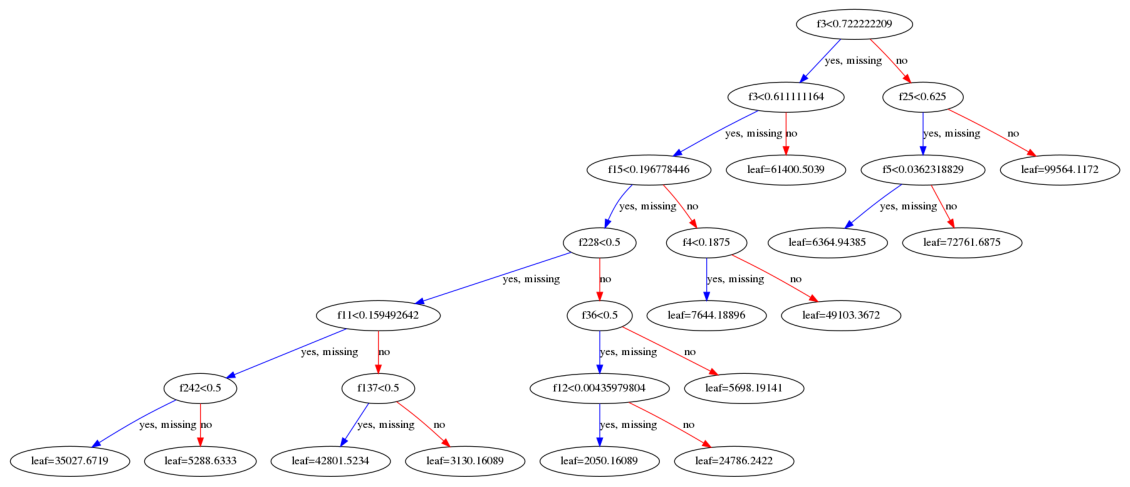

In [89]:
from xgboost import plot_tree
import matplotlib.pyplot as plt
# load data
plt.rcParams["figure.figsize"] = (20,20)
# plot single tree
plot_tree(xg_reg_final)
plt.show()

In [90]:
print(labels[1:])

['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'C (all)', 'FV', 'RH', 'RL', 'RM', 'nan', 'Grvl', 'Pave', 'Grvl', 'Pave', 'nan', 'IR1', 'IR2', 'IR3', 'Reg', 'Bnk', 'HLS', 'Low', 'Lvl', 'AllPub', 'NoSeWa', 'nan', 'Corner', 'CulDSac', 'FR2', 'FR3', 'Inside', 'Gtl', 'Mod', 'Sev', 'Blmngtn', 'Blueste', 'BrDale', 'BrkSide', 'ClearCr', 'CollgCr', 'Crawfor', 'Edwards', 'Gilbert', 'IDOTRR', 'MeadowV', 'Mitchel', 'NAmes', 'NPkVill', 'NWAmes', 'NoRidge', 'NridgHt', 'OldTown', 'SWISU', 'Sawyer', 'SawyerW', 'Somerst', 'StoneBr', 'Timber', 'Veenker', 'Ar

In [91]:
### PCA Analysis

from sklearn.decomposition import PCA
pca = PCA(n_components = 5)
pca.fit(train_arr)
print(pca.explained_variance_ratio_)

new_dat = pca.transform(train_arr)

pca.

[0.14817583 0.05812861 0.03690596 0.03362664 0.03050086]


In [93]:
new_df = pd.DataFrame(pca.components_,columns=labels[1:],index = ['PC-1','PC-2','PC-3','PC-4','PC-5']).abs()




In [94]:
new_df

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,New,Oth,WD,nan,Abnorml,AdjLand,Alloca,Family,Normal,Partial
PC-1,0.004619,0.009232,0.001989,0.073111,0.022872,0.115577,0.160286,0.024672,0.010957,0.007753,...,0.072370,0.000863,0.058029,0.0,0.019229,0.001547,0.002522,0.003685,0.045521,0.072506
PC-2,0.072721,0.025364,0.010542,0.006892,0.000299,0.052090,0.032199,0.029214,0.035524,0.025098,...,0.036739,0.000405,0.030151,0.0,0.008140,0.002104,0.000697,0.000433,0.046275,0.037161
PC-3,0.099638,0.004080,0.002325,0.007181,0.021347,0.014435,0.010585,0.002757,0.015670,0.003236,...,0.131841,0.002752,0.153719,0.0,0.023412,0.002346,0.003818,0.002467,0.167383,0.135339
PC-4,0.065272,0.032640,0.014516,0.054956,0.018938,0.066401,0.017259,0.025855,0.002353,0.000923,...,0.082824,0.002580,0.084510,0.0,0.002636,0.000964,0.003575,0.002664,0.078923,0.083434
PC-5,0.110662,0.013683,0.008776,0.047153,0.001952,0.019206,0.001579,0.064545,0.007285,0.012599,...,0.032597,0.003230,0.037589,0.0,0.012915,0.004806,0.002718,0.006750,0.017730,0.031418


In [111]:
max_val = new_df.max(axis =1)
new_df_arr = new_df.to_numpy()
argmax_val = np.argmax(new_df_arr, axis = 1)
max_val2 = np.max(new_df_arr, axis =1)

new_labels = labels[1:]
new_big_labels = big_labels[1:]

max_components = [new_labels[a] for a in argmax_val]
max_big_components = [new_big_labels[a] for a in argmax_val]

for i in range(5):
    print(max_big_components[i])
    print(max_components[i])
    print(new_df.iloc[i,argmax_val[i]])
    print("\n")



Foundation
PConc
0.2586207142150227


Foundation
CBlock
0.2727207632185443


HouseStyle
1Story
0.4524165521569724


FireplaceQu
nan
0.35756279000275354


LotShape
Reg
0.3662797047575845


